In [1]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

print("--- [สร้างฐานข้อมูล] ---")

full_csv_filename = 'GlobalFoodPricesFull.csv'
db_filename = 'global_food_prices.db'
table_name = 'food_prices'

try:
    print(f"กำลังอ่านไฟล์ CSV ขนาดใหญ่: {full_csv_filename}...")
    df_full = pd.read_csv(full_csv_filename, low_memory=False)
    
    print(f"อ่านไฟล์สำเร็จ มี {len(df_full)} แถว")
    
    engine = create_engine(f'sqlite:///{db_filename}')
    
    print(f"กำลังเขียนข้อมูลลงตาราง '{table_name}' ในฐานข้อมูล '{db_filename}'...")
    df_full.to_sql(table_name, engine, index=False, if_exists='replace')
    
    print(f"สร้างตาราง '{table_name}' สำเร็จ!")
    
except FileNotFoundError:
    print(f"!!! ข้อผิดพลาด: ไม่พบไฟล์ '{full_csv_filename}'")
except Exception as e:
    print(f"เกิดข้อผิดพลาดระหว่างสร้างฐานข้อมูล: {e}")

--- [สร้างฐานข้อมูล] ---
กำลังอ่านไฟล์ CSV ขนาดใหญ่: GlobalFoodPricesFull.csv...
อ่านไฟล์สำเร็จ มี 3109617 แถว
กำลังเขียนข้อมูลลงตาราง 'food_prices' ในฐานข้อมูล 'global_food_prices.db'...
สร้างตาราง 'food_prices' สำเร็จ!


In [2]:
import pandas as pd
import sqlite3
import numpy as np
import warnings

warnings.filterwarnings('ignore')

print("--- [ขั้นตอนที่ 1 & 2] (ฉบับใหม่: กรองเฉพาะ 'อาหาร 10 อย่าง') ---")

db_filename = 'global_food_prices.db'
table_name = 'food_prices'

commodities_to_analyze = (
    'Rice', 'Wheat', 'Bread', 'Wheat flour', 'Maize', 
    'Eggs', 'Milk (pasteurized)', 'Meat (chicken)', 'Potatoes', 'Tomatoes' 
)

query = f"""
    SELECT 
        date, 
        country_code, 
        market, 
        commodity, 
        price_usd,
        category 
    FROM {table_name}
    WHERE 
        price_type = 'Retail' 
        AND commodity IN {commodities_to_analyze}
"""

print(f"กำลังเชื่อมต่อกับ '{db_filename}' และดึงข้อมูลอาหาร 10 อย่าง...")

try:
    conn = sqlite3.connect(db_filename)
    df = pd.read_sql(query, conn) 
    conn.close()
    
    print(f"ดึงข้อมูลสำเร็จ! ได้ข้อมูลมา {len(df)} แถว")

    rows_before = len(df)
    df.dropna(subset=['price_usd'], inplace=True)
    rows_after = len(df)
    print(f"[Pre-processing 1] ลบแถวที่ 'price_usd' เป็นค่าว่าง: ลบไป {rows_before - rows_after} แถว")

    df['date'] = pd.to_datetime(df['date'])
    print("[Pre-processing 2] แปลงคอลัมน์ 'date' เป็นชนิด datetime สำเร็จ")

    print("\n--- ข้อมูล 'หลัง' การทำความสะอาด (พร้อมใช้งาน) ---")
    print(df.info())
    print("\n--- ตรวจสอบสินค้า 10 ชนิด ---")
    print(f"สินค้าทั้งหมดที่ดึงมา: {df['commodity'].nunique()} ชนิด")
    print(df['commodity'].unique())


except Exception as e:
    print(f"!!! เกิดข้อผิดพลาด: {e}")

--- [ขั้นตอนที่ 1 & 2] (ฉบับใหม่: กรองเฉพาะ 'อาหาร 10 อย่าง') ---
กำลังเชื่อมต่อกับ 'global_food_prices.db' และดึงข้อมูลอาหาร 10 อย่าง...
ดึงข้อมูลสำเร็จ! ได้ข้อมูลมา 402587 แถว
[Pre-processing 1] ลบแถวที่ 'price_usd' เป็นค่าว่าง: ลบไป 178 แถว
[Pre-processing 2] แปลงคอลัมน์ 'date' เป็นชนิด datetime สำเร็จ

--- ข้อมูล 'หลัง' การทำความสะอาด (พร้อมใช้งาน) ---
<class 'pandas.core.frame.DataFrame'>
Index: 402409 entries, 0 to 402586
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          402409 non-null  datetime64[ns]
 1   country_code  402409 non-null  object        
 2   market        402409 non-null  object        
 3   commodity     402409 non-null  object        
 4   price_usd     402409 non-null  float64       
 5   category      402409 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 21.5+ MB
None

--- ตรวจสอบสินค้า 10 ชนิด ---
สินค้าทั้งหมดที่ดึงม

In [3]:
print("\n--- [ขั้นตอนที่ 3] เริ่มต้นการทำ Feature Engineering ---")

import re 

try:

    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Quarter'] = df['date'].dt.quarter
    print("[Feature Eng. 1] สร้างตัวแปร Year, Month, Quarter สำเร็จ")

    features_to_encode = ['country_code', 'commodity', 'category'] 
    print(f"[Feature Eng. 2] กำลังแปลง {features_to_encode} ด้วย One-Hot Encoding...")
    
    df_encoded = pd.get_dummies(df, columns=features_to_encode, drop_first=True)
    print("[Feature Eng. 2] แปลง One-Hot Encoding สำเร็จ")

    y = df_encoded['price_usd']
    X = df_encoded.drop(columns=[
        'date',
        'market',
        'price_usd' 
    ])
    
    print("[Feature Eng. 3] กำลังล้าง (Sanitize) ชื่อคอลัมน์สำหรับ LightGBM...")
    
    X.columns = [re.sub(r'[\[\]()<,]', '_', col) for col in X.columns]
    
    print("[Feature Eng. 3] ล้างชื่อคอลัมน์สำเร็จ!")

    print("\n--- Feature Engineering เสร็จสิ้น! ---")
    print("โครงสร้าง Features (X) ทั้งหมด:")
    X.info()

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างทำ Feature Engineering: {e}")


--- [ขั้นตอนที่ 3] เริ่มต้นการทำ Feature Engineering ---
[Feature Eng. 1] สร้างตัวแปร Year, Month, Quarter สำเร็จ
[Feature Eng. 2] กำลังแปลง ['country_code', 'commodity', 'category'] ด้วย One-Hot Encoding...
[Feature Eng. 2] แปลง One-Hot Encoding สำเร็จ
[Feature Eng. 3] กำลังล้าง (Sanitize) ชื่อคอลัมน์สำหรับ LightGBM...
[Feature Eng. 3] ล้างชื่อคอลัมน์สำเร็จ!

--- Feature Engineering เสร็จสิ้น! ---
โครงสร้าง Features (X) ทั้งหมด:
<class 'pandas.core.frame.DataFrame'>
Index: 402409 entries, 0 to 402586
Data columns (total 98 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   Year                            402409 non-null  int32
 1   Month                           402409 non-null  int32
 2   Quarter                         402409 non-null  int32
 3   country_code_AGO                402409 non-null  bool 
 4   country_code_ARG                402409 non-null  bool 
 5   country_code_ARM                40

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

print("\n--- [ขั้นตอนที่ 4] (ฉบับอัปเกรด: ทดลอง 5 โมเดล) ---")

try:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"แบ่งข้อมูล: {len(X_train)} แถวสำหรับ Train, {len(X_test)} แถวสำหรับ Test")

    models = {
        "1. Linear Regression": LinearRegression(),
        "2. Ridge Regression": Ridge(random_state=42),
        "3. Decision Tree": DecisionTreeRegressor(random_state=42),
        "4. Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        "5. LightGBM (LGBM)": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    }

    model_names = []
    r2_scores = []
    mae_scores = []

    for name, model in models.items():
        print(f"\nกำลังเทรนโมเดล: {name}...")
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        model_names.append(name)
        r2_scores.append(r2)
        mae_scores.append(mae)
        
        print(f"ผลลัพธ์ {name}: R-squared = {r2:.4f}, MAE = {mae:.4f}")

    print("\n--- ตารางเปรียบเทียบประสิทธิภาพโมเดล (Scoreboard) ---")
    
    scoreboard = pd.DataFrame({
        'Algorithm': model_names,
        'R-squared': r2_scores,
        'Mean Absolute Error (MAE)': mae_scores
    })
    
    scoreboard_sorted = scoreboard.sort_values(by='R-squared', ascending=False)
    
    print(scoreboard_sorted)
    
    print("\n--- [Dynamic] การบันทึกผลลัพธ์ Baseline อัตโนมัติ ---")
    
    best_model_row = scoreboard_sorted.iloc[0]
    
    best_model_name = best_model_row['Algorithm']
    baseline_r2 = best_model_row['R-squared']
    baseline_mae = best_model_row['Mean Absolute Error (MAE)']
    
    print(f"โมเดลที่ดีที่สุดคือ: {best_model_name}")
    print(f"กำลังส่งค่า R2={baseline_r2:.4f}, MAE={baseline_mae:.4f} ไปยังขั้นตอนที่ 5...")

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างการเทรนโมเดล: {e}")


--- [ขั้นตอนที่ 4] (ฉบับอัปเกรด: ทดลอง 5 โมเดล) ---
แบ่งข้อมูล: 321927 แถวสำหรับ Train, 80482 แถวสำหรับ Test

กำลังเทรนโมเดล: 1. Linear Regression...
ผลลัพธ์ 1. Linear Regression: R-squared = 0.3256, MAE = 1.6156

กำลังเทรนโมเดล: 2. Ridge Regression...
ผลลัพธ์ 2. Ridge Regression: R-squared = 0.3262, MAE = 1.6156

กำลังเทรนโมเดล: 3. Decision Tree...
ผลลัพธ์ 3. Decision Tree: R-squared = 0.9158, MAE = 0.2776

กำลังเทรนโมเดล: 4. Random Forest...
ผลลัพธ์ 4. Random Forest: R-squared = 0.9206, MAE = 0.2761

กำลังเทรนโมเดล: 5. LightGBM (LGBM)...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 321927, number of used features: 98
[LightGBM] [Info] St

In [5]:
from sklearn.model_selection import GridSearchCV

print("\n--- [ขั้นตอนที่ 5] เริ่มต้นการปรับปรุงพารามิเตอร์ (Fine-tuning) ---")
try:
    print(f"เราจะจูนโมเดล: '{best_model_name}' (ที่รับค่ามาจากขั้นตอนที่ 4)")
    print(f"Baseline (จากขั้นตอนที่ 4): R2={baseline_r2:.4f}, MAE={baseline_mae:.4f}")
except NameError:
    print("!!! ไม่พบตัวแปร best_model_name !!!")
    print("!!! กรุณารัน Cell ที่ 3 (ขั้นตอนที่ 4) ก่อน!!!")
    raise

estimator_blueprints = {
    "1. Linear Regression": LinearRegression(),
    "2. Ridge Regression": Ridge(random_state=42),
    "3. Decision Tree": DecisionTreeRegressor(random_state=42),
    "4. Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "5. LightGBM (LGBM)": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

param_grids = {
    "1. Linear Regression": {},
    "2. Ridge Regression": {
        'alpha': [0.5, 1.0, 5.0] 
    },
    "3. Decision Tree": {
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 5, 10]
    },
    "4. Random Forest": {
        'n_estimators': [100, 200], 
        'max_depth': [10, 20, None]
    },
    "5. LightGBM (LGBM)": {
        'num_leaves': [31, 50],
        'n_estimators': [100, 200]
    }
}

estimator_to_tune = estimator_blueprints[best_model_name]
param_grid_to_use = param_grids[best_model_name]

if not param_grid_to_use:
    print(f"\nโมเดล '{best_model_name}' ไม่จำเป็นต้อง/ไม่สามารถ Fine-tune ได้")
    
else:
    grid_search = GridSearchCV(
        estimator=estimator_to_tune, 
        param_grid=param_grid_to_use, 
        cv=3, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1 # 
    )

    print(f"\nกำลังเริ่ม GridSearchCV สำหรับ '{best_model_name}'...")
    
    grid_search.fit(X_train, y_train)

    print("GridSearchCV เสร็จสิ้น!")
    
    print(f"\nParameters ที่ดีที่สุดที่ค้นพบ: {grid_search.best_params_}")

    best_tuned_model = grid_search.best_estimator_
    y_pred_tuned = best_tuned_model.predict(X_test)
    
    tuned_r2 = r2_score(y_test, y_pred_tuned)
    tuned_mae = mean_absolute_error(y_test, y_pred_tuned)

    print("\n--- สรุปผลการ Fine-tuning ---")
    print(f"Baseline (โมเดลเดิม): R2={baseline_r2:.4f}, MAE={baseline_mae:.4f}")
    print(f"Tuned (โมเดลใหม่):   R2={tuned_r2:.4f}, MAE={tuned_mae:.4f}")

    mae_improvement_percent = ((baseline_mae - tuned_mae) / baseline_mae) * 100
    
    print("\n--- ผลลัพธ์สำหรับนำเสนอ (ข้อ 5) ---")
    if tuned_mae < baseline_mae:
        print(f"สรุป: เราปรับปรุงโมเดล 1 ตัว ({best_model_name}) ได้สำเร็จ")
        print(f"ประสิทธิภาพดีขึ้น โดยลดค่า Error (MAE) ลงได้ {mae_improvement_percent:.2f} %")
    else:
        print(f"สรุป: โมเดลที่จูนแล้ว ({best_model_name}) มีประสิทธิภาพใกล้เคียง/ด้อยกว่าโมเดลพื้นฐาน")


--- [ขั้นตอนที่ 5] เริ่มต้นการปรับปรุงพารามิเตอร์ (Fine-tuning) ---
เราจะจูนโมเดล: '5. LightGBM (LGBM)' (ที่รับค่ามาจากขั้นตอนที่ 4)
Baseline (จากขั้นตอนที่ 4): R2=0.9262, MAE=0.4083

กำลังเริ่ม GridSearchCV สำหรับ '5. LightGBM (LGBM)'...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 321927, number of used features: 98
[LightGBM] [Info] Start training from score 1.798994
GridSearchCV เสร็จสิ้น!

Parameters ที่ดีที่สุดที่ค้นพบ: {'n_estimators': 200, 'num_leaves': 50}

--- สรุปผลการ Fine-tuning ---
Baseline (โมเดลเดิม): R2=0.9262, MAE=0.4083
Tuned (โมเดลใหม่):   R2=0.9286, MAE=0.3418


--- [ขั้นตอนที่ 6] เริ่มต้นการวิเคราะห์และสร้างกราฟ (Visualization) ---
กำลังสร้าง กราฟที่ 1: แนวโน้มราคาระยะยาว (Line Plot)


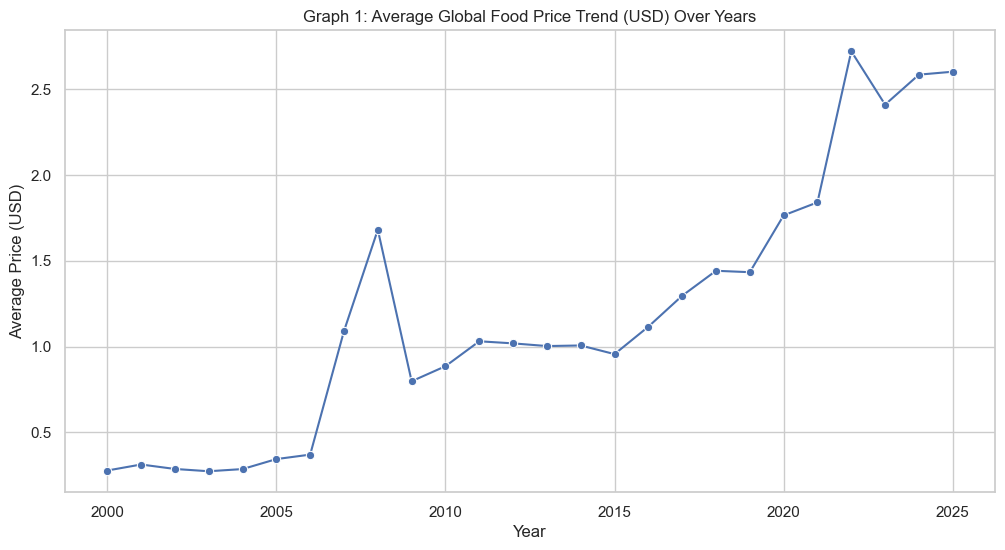


กำลังสร้าง กราฟที่ 2: เปรียบเทียบราคาสินค้า (Bar Plot)


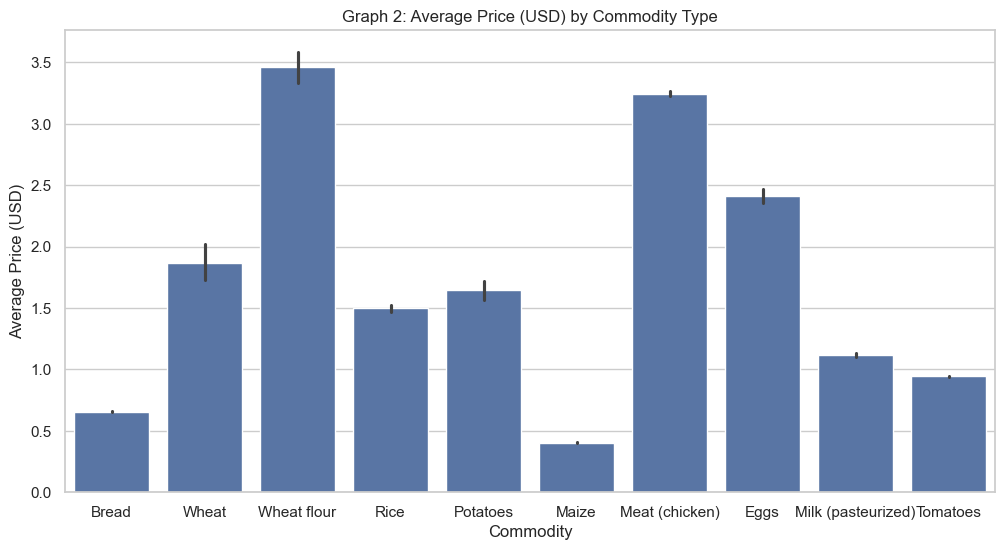


กำลังสร้าง กราฟที่ 3: การกระจายตัวของราคา (Box Plot) [แบบซ่อน Outliers]


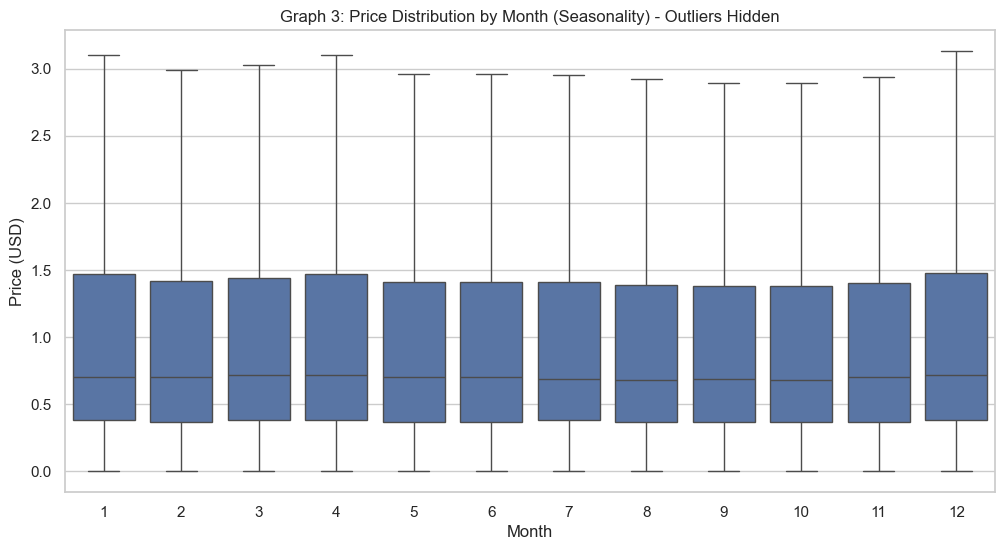

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- [ขั้นตอนที่ 6] เริ่มต้นการวิเคราะห์และสร้างกราฟ (Visualization) ---")

sns.set_theme(style="whitegrid")

try:
    print("กำลังสร้าง กราฟที่ 1: แนวโน้มราคาระยะยาว (Line Plot)")
    
    df_yearly_price = df.groupby('Year')['price_usd'].mean().reset_index()
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    
    sns.lineplot(data=df_yearly_price, x='Year', y='price_usd', marker='o', ax=ax1)
    
    ax1.set_title('Graph 1: Average Global Food Price Trend (USD) Over Years')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average Price (USD)')
    plt.show()
    
    print("\nกำลังสร้าง กราฟที่ 2: เปรียบเทียบราคาสินค้า (Bar Plot)")
    
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    
    sns.barplot(data=df, x='commodity', y='price_usd', ax=ax2)
    
    ax2.set_title('Graph 2: Average Price (USD) by Commodity Type')
    ax2.set_xlabel('Commodity')
    ax2.set_ylabel('Average Price (USD)')
    plt.show()

    print("\nกำลังสร้าง กราฟที่ 3: การกระจายตัวของราคา (Box Plot) [แบบซ่อน Outliers]")
    
    fig3, ax3 = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df, x='Month', y='price_usd', showfliers=False, ax=ax3) 
    
    ax3.set_title('Graph 3: Price Distribution by Month (Seasonality) - Outliers Hidden')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Price (USD)')
    plt.show()

except Exception as e:
    print(f"!!! เกิดข้อผิดพลาดระหว่างการสร้างกราฟ: {e}")
    print("!!! กรุณาตรวจสอบว่า DataFrame 'df' ยังอยู่ใน Memory")